In [1]:
import datetime
principio = datetime.datetime.now()

In [2]:
import warnings
warnings.filterwarnings('ignore')
# version 2.03

# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
# %%
from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.models import TBATS
from darts.metrics import mape


Bad key savefig.frameon in file C:\Users\manue\anaconda3\envs\TecnicasPrediccion\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\manue\anaconda3\envs\TecnicasPrediccion\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\manue\anaconda3\envs\TecnicasPrediccion\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.std

In [3]:
# Read Data
data = pd.read_csv('../data/datos sin días.csv')
# data.set_index('Fecha', inplace=True)
series = TimeSeries.from_dataframe(data, 'Fecha', 'Billetes')

<AxesSubplot:>

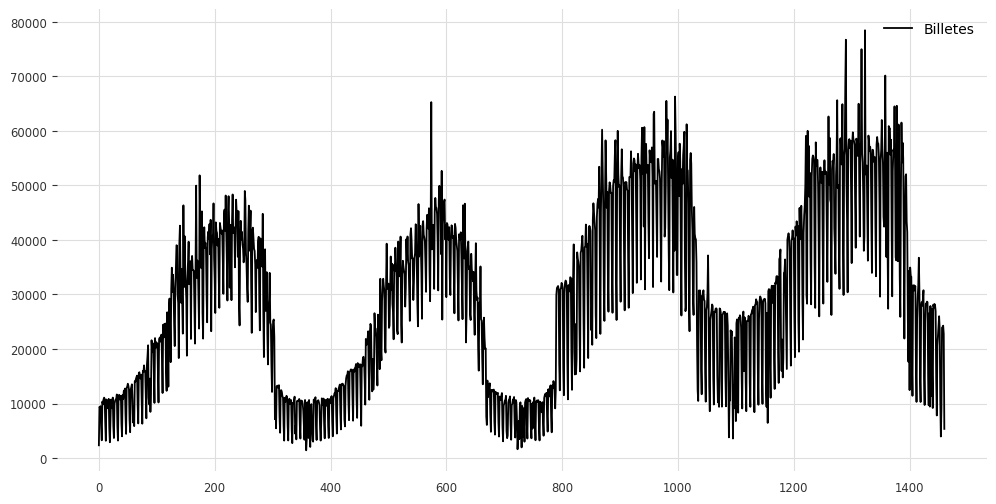

In [4]:
plt.rcParams["figure.figsize"] = (12,6)
data.plot()

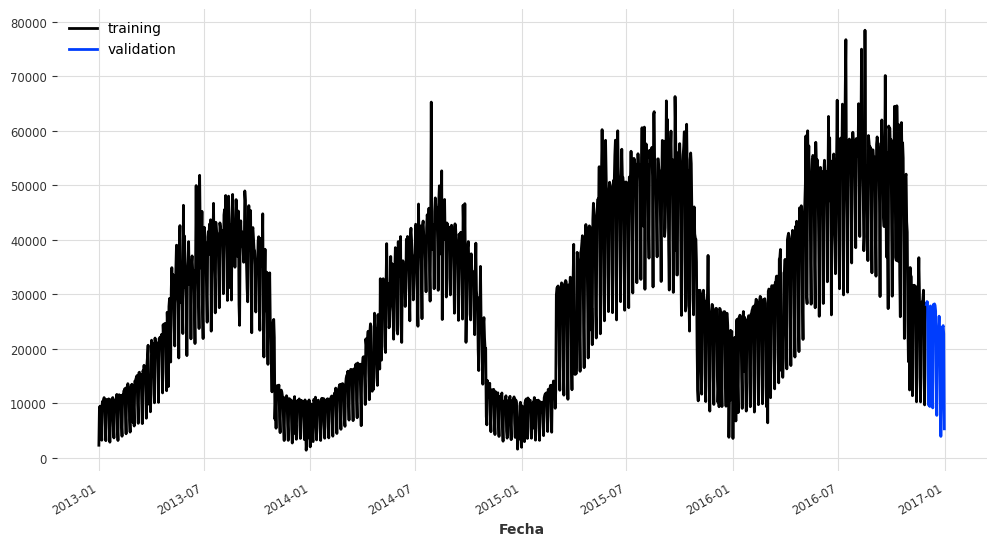

In [5]:
# %%
train, val = series.split_before(pd.Timestamp('2016-11-30'))
train.plot(label="training")
val.plot(label="validation")

In [6]:
train

<TimeSeries (DataArray) (Fecha: 1429, component: 1, sample: 1)>
array([[[ 2338.]],

       [[ 9376.]],

       [[ 9190.]],

       ...,

       [[ 9729.]],

       [[24917.]],

       [[28318.]]])
Coordinates:
  * Fecha      (Fecha) datetime64[ns] 2013-01-01 2013-01-02 ... 2016-11-29
  * component  (component) object 'Billetes'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [7]:
#@title

# %%
#from darts.models import TBATS
#from darts.metrics import mape

model =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1), #MANU: valors mínimos y máximos de la transformación
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)
model.fit(train)
forecast = model.predict(len(val))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))




model TBATS() obtains MAPE: 43.07%


In [8]:
model.model.params.summary()

'Use Box-Cox: True\nUse trend: False\nUse damped trend: False\nSeasonal periods: [7.]\nSeasonal harmonics [3]\nARMA errors (p, q): (3, 3)\nBox-Cox Lambda 0.344304\nSmoothing (Alpha): 0.497230\nSeasonal Parameters (Gamma): [ 1.49297097e-05 -1.32201619e-05]\nAR coefficients [-1.32201619e-05  1.90022485e-01 -1.70533486e-01]\nMA coefficients [-0.13392105 -0.43057588  0.09485123]\nSeed vector [59.02290539  4.78747279  3.36253253 -2.70317439  7.12494822 -4.59684312\n -1.54005947  0.          0.          0.          0.          0.\n  0.        ]\n'

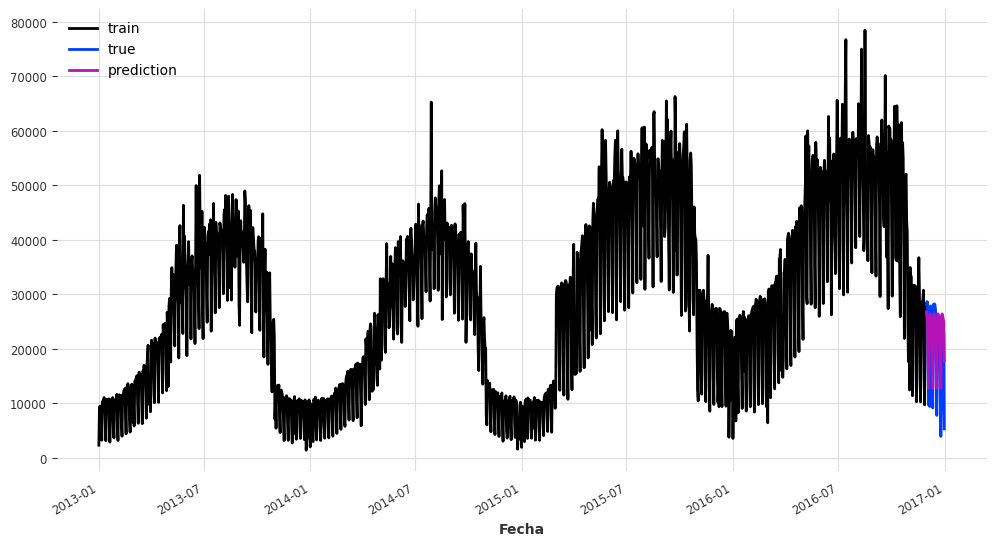

In [9]:
# %%
train.plot(label="train")
val.plot(label="true")
forecast.plot(label="prediction")

# Usar SKTIME

In [10]:
# Read Data
from sktime.forecasting.model_selection import temporal_train_test_split

data = pd.read_csv('../data/datos sin días.csv')
data.set_index('Fecha', inplace=True)
data.index = pd.to_datetime(data.index)
data = data['Billetes']
data.index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data

2013-01-01     2338
2013-01-02     9376
2013-01-03     9190
2013-01-04     9523
2013-01-05     5492
              ...  
2016-12-27    23928
2016-12-28    23960
2016-12-29    24279
2016-12-30    22763
2016-12-31     5346
Freq: D, Name: Billetes, Length: 1461, dtype: int64

In [11]:
y_train, y_test = temporal_train_test_split(data, test_size=31)

In [12]:
y_train

2013-01-01     2338
2013-01-02     9376
2013-01-03     9190
2013-01-04     9523
2013-01-05     5492
              ...  
2016-11-26    14941
2016-11-27     9729
2016-11-28    24917
2016-11-29    28318
2016-11-30    28141
Freq: D, Name: Billetes, Length: 1430, dtype: int64

In [13]:
from sktime.forecasting.tbats import TBATS # MODELO TBATS

forecaster = TBATS(
    use_box_cox=None,
    use_trend=None,
    use_damped_trend=None,
    use_arma_errors=True,
    n_jobs=1
)

forecaster.fit(y_train)


TBATS(n_jobs=1)

In [14]:
import numpy as np
y_pred = forecaster.predict(fh=np.arange(1, 32))



(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='Billetes'>)

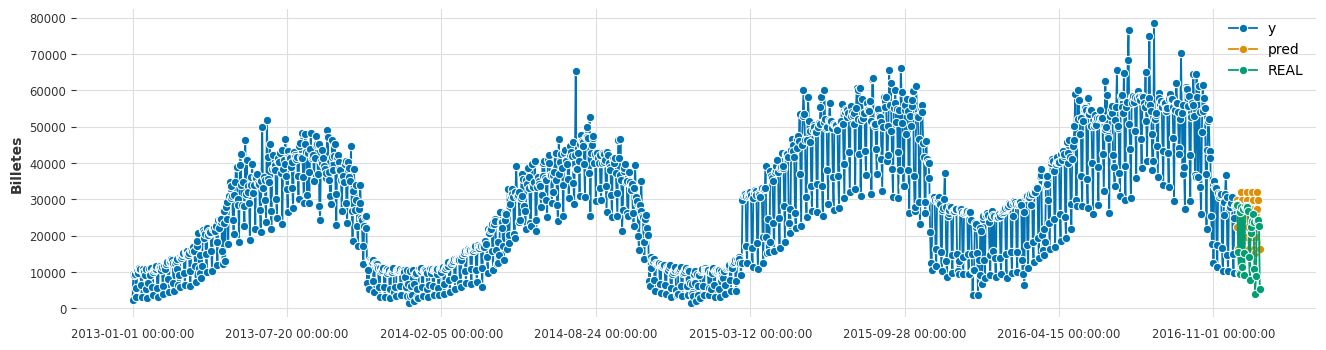

In [15]:
# optional: plotting predictions and past data
plot_series(y_train, y_pred, y_test, labels=["y", "pred", "REAL"])

In [16]:
# Sktime fucntions
# Forecast Accuracy MAPE & MSE & RMSE
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
# Forecast Accuracy
# MAPE
mean_absolute_percentage_error(y_test, y_pred)

0.500252243020273

# Cross Validation: Historical

In [17]:
from darts.models import TBATS
from darts.metrics import mape
#Vuelvo a la librería de Darts porque ahora quiero hacer validación cruzada

In [18]:
historical_fcast_tbats = model.historical_forecasts(series, start=0.9, forecast_horizon=12, verbose=True, stride=1)

series.plot(label="data")
historical_fcast_tbats.plot(label="backtest 12-months ahead forecast (Tbats)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_tbats, series)))

  0%|          | 0/136 [00:00<?, ?it/s]

PermissionError: [WinError 5] Acceso denegado

In [19]:
model_best =TBATS(
use_box_cox=True,
box_cox_bounds=(0, 0),
use_trend=True,
use_damped_trend=False,
seasonal_periods="freq",
use_arma_errors=False,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)

In [20]:
# %%
historical_fcast_tbats = model_best.historical_forecasts(
    series, start=0.4, forecast_horizon=12, verbose=True, stride=1
)

series.plot(label="data")
historical_fcast_tbats.plot(label="backtest 12-months ahead forecast (Tbats)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_tbats, series)))


  0%|          | 0/866 [00:00<?, ?it/s]

PermissionError: [WinError 5] Acceso denegado

## BackTest

In [ ]:
raw_errors = model_best.backtest(
    series, 
    start=0.9, 
    forecast_horizon=12, 
    metric=mape, 
    reduction=None, # None: return errors
    verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [ ]:
average_error = model.backtest(
    series,
    start=0.4,
    forecast_horizon=12,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)
print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

In [ ]:
average_error

In [ ]:
raw_errors

# MODELO DE VENTAS

In [ ]:
# Read Data
data = pd.read_csv('../data/datos sin días.csv')
data.set_index('Fecha', inplace=True)
data_festivos_dias_semana = pd.read_csv('../data/datos con días.csv')
data_festivos_dias_semana.set_index('Fecha', inplace=True)

In [ ]:
data_st = data[(data['store'] == 1) & (data['item'] == 1)] # item 1 en store 1
data_st = data_st.set_index('date')
data_st.tail()

In [ ]:
df_st.sales.plot()

In [ ]:
from darts.timeseries import TimeSeries
df = df[(df['store'] == 1) & (df['item'] == 1)] # item 1 en store 1
serie=TimeSeries.from_dataframe(df, time_col="date",value_cols="Billetes",freq="D")

In [ ]:
serie.plot()

In [ ]:
serie

In [ ]:
# TRAIN TEST
train,test=serie.split_before(0.85)
train.plot(label="training")
test.plot(label="testing")

In [ ]:

model_billetes =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods=(7,365.25), #MANU: Estacionalidad diaria y anual (se pueden poner más).  Cuando ponemos "freq" lo hace con frecuencia diaria (ver donde pone antes "freq="D"") 
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)

model_billetes.fit(train)

In [ ]:
forecast = model_billetes.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(model_billetes, mape(test, forecast)))

In [ ]:
model_billetes.model.params.summary()

In [ ]:
train.plot(label="train")
test.plot(label="true")
forecast.plot(label="prediction")
#MANU: Antes la predicción (m0rado) iba bien, pero como hemos cambiado los seasonal periods y hemos puesto "freq", cambia
#lo volvemos a cambiar.

In [ ]:
#zoom plot

train[-400:].plot(label="train")
test.plot(label="true")
forecast.plot(label="prediction")

In [ ]:
final = datetime.datetime.now()
final-principio